In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

import numpy as np
import os
import random
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
from sklearn.preprocessing import StandardScaler
import util
from datetime import date
import argparse
from progressbar import *

# ONE OF THE BEST: put embeding 10 ken results 3ejboukich


### Likelihood layers:

In [ ]:
class Gaussian_layer(nn.Module):

    def __init__(self, hidden_size, output_size):
        '''
        Gaussian Likelihood Supports Continuous Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(Gaussian_layer, self).__init__()
        self.mu_layer = nn.Linear(hidden_size, output_size)
        self.sigma_layer = nn.Linear(hidden_size, output_size)

        # initialize weights
        # nn.init.xavier_uniform_(self.mu_layer.weight)
        # nn.init.xavier_uniform_(self.sigma_layer.weight)

    def forward(self, h):
        _, hidden_size = h.size()
        sigma_t = torch.log(1 + torch.exp(self.sigma_layer(h))) + 1e-6
        sigma_t = sigma_t.squeeze(0)
        mu_t = self.mu_layer(h).squeeze(0)
        return mu_t, sigma_t

In [ ]:
class NegativeBinomial(nn.Module):

    def __init__(self, input_size, output_size):
        '''
        Negative Binomial Supports Positive Count Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(NegativeBinomial, self).__init__()
        self.mu_layer = nn.Linear(input_size, output_size)
        self.sigma_layer = nn.Linear(input_size, output_size)

    def forward(self, h):
        _, hidden_size = h.size()
        alpha_t = torch.log(1 + torch.exp(self.sigma_layer(h))) + 1e-6
        mu_t = torch.log(1 + torch.exp(self.mu_layer(h)))
        return mu_t, alpha_t

In [ ]:
class Gamma_layer(nn.Module):

    def __init__(self, hidden_size, output_size):
        '''
        Gamma Likelihood Supports Continuous Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(Gamma_layer, self).__init__()
        self.alpha_layer = nn.Linear(hidden_size, output_size)
        self.beta_layer = nn.Linear(hidden_size, output_size)


    def forward(self, h):
        _, hidden_size = h.size()

        alpha_t = torch.log(1 + torch.exp(self.alpha_layer(h))) # 1e-6 apply softplus to make sure the params are > 0
        beta_t = torch.log(1 + torch.exp(self.beta_layer(h)))  #1e-6

        return alpha_t, beta_t

In [ ]:
class Betaprm_layer(nn.Module):

    def __init__(self, hidden_size, output_size):
        '''
        Beta prime Likelihood Supports Continuous Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(Betaprm_layer, self).__init__()
        self.alpha_layer = nn.Linear(hidden_size, output_size)
        self.beta_layer = nn.Linear(hidden_size, output_size)


    def forward(self, h):
        _, hidden_size = h.size()
        alpha_t = torch.log(1 + torch.exp(self.alpha_layer(h))) + 1e-6
        beta_t = torch.log(1 + torch.exp(self.beta_layer(h)))  +1e-6

        # print(f'alpha= {alpha_t}, beta = {beta_t} ')
        return alpha_t, beta_t

In [ ]:
class Igamma_layer(nn.Module):

    def __init__(self, hidden_size, output_size):
        '''
        Beta prime Likelihood Supports Continuous Data
        Args:
        input_size (int): hidden h_{i,t} column size
        output_size (int): embedding size
        '''
        super(Igamma_layer, self).__init__()
        self.alpha_layer = nn.Linear(hidden_size, output_size)
        self.beta_layer = nn.Linear(hidden_size, output_size)


    def forward(self, h):
        _, hidden_size = h.size()
        alpha_t = torch.log(1 + torch.exp(self.alpha_layer(h))) + 1e-6
        beta_t = torch.log(1 + torch.exp(self.beta_layer(h)))  +1e-6

        # print(f'alpha= {alpha_t}, beta = {beta_t} ')
        return alpha_t, beta_t

### Sampling layers:

In [ ]:
def gaussian_sample(mu, sigma):
    '''
    Gaussian Sample
    Args:
    ytrue (array like)
    mu (array like)
    sigma (array like): standard deviation

    gaussian maximum likelihood using log
        l_{G} (z|mu, sigma) = (2 * pi * sigma^2)^(-0.5) * exp(- (z - mu)^2 / (2 * sigma^2))
    '''
    # likelihood = (2 * np.pi * sigma ** 2) ** (-0.5) * \
    #         torch.exp((- (ytrue - mu) ** 2) / (2 * sigma ** 2))
    # return likelihood
    gaussian = torch.distributions.normal.Normal(mu, sigma)
    ypred = gaussian.sample(mu.size())
    return ypred


In [ ]:
def negative_binomial_sample(mu, alpha):
    '''
    Negative Binomial Sample
    Args:
    ytrue (array like)
    mu (array like)
    alpha (array like)

    maximuze log l_{nb} = log Gamma(z + 1/alpha) - log Gamma(z + 1) - log Gamma(1 / alpha)
                - 1 / alpha * log (1 + alpha * mu) + z * log (alpha * mu / (1 + alpha * mu))

    minimize loss = - log l_{nb}

    Note: torch.lgamma: log Gamma function
    '''
    var = mu + mu * mu * alpha
    ypred = mu + torch.randn(mu.size()) * torch.sqrt(var)
    return ypred

In [ ]:
def gamma_sample(alpha, beta):
    '''
    Gamma Sample
    Args:
    ytrue (array like)
    alpha (array like)
    beta (array like):
    '''
    gamma = torch.distributions.gamma.Gamma(alpha,beta)
    ypred = gamma.sample(alpha.size())

    return ypred

In [ ]:
from scipy.stats import betaprime
def Betaprm_sample(alpha, beta):
    '''
    Beta prime Sample
    Args:
    ytrue (array like)
    alpha (array like)
    beta (array like):
    '''
    # print(f'alpha {alpha}, beta {beta}')
    a = betaprime.rvs(alpha.item(), beta.item())
    # print(type(a))
    return torch.tensor([[a]]).float()

In [ ]:
from scipy.stats import invgamma
def Igamma_sample(alpha, beta):
    '''
    Beta prime Sample
    Args:
    ytrue (array like)
    alpha (array like)
    beta (array like):
    '''
    # print(f'alpha {alpha}, beta {beta}')
    a = invgamma.rvs(alpha.item())
    # print(type(a))
    return torch.tensor([[a]]).float()

In [ ]:
from scipy.stats import invgauss
def Igaussian_sample(mu, sigma):
    '''
    Beta prime Sample
    Args:
    ytrue (array like)
    alpha (array like)
    beta (array like):
    '''
    # print(f'alpha {alpha}, beta {beta}')
    a = invgauss.rvs(mu.item())
    # print(type(a))
    return torch.tensor([[a]]).float()

### Main:

In [ ]:
class DeepAR(nn.Module):

    def __init__(self, input_size, embedding_size, hidden_size, num_layers, lr=1e-3, likelihood="g"):
        super(DeepAR, self).__init__()

        # network
        self.input_embed = nn.Linear(1, embedding_size)
        self.encoder = nn.LSTM(embedding_size+input_size, hidden_size, \
                num_layers, bias=True, batch_first=True)
        #####################
        if likelihood == "g":
            self.likelihood_layer = Gaussian_layer(hidden_size, 1)
        elif likelihood == "Ig":
            self.likelihood_layer = Gaussian_layer(hidden_size, 1)
        elif likelihood == "nb":
            self.likelihood_layer = NegativeBinomial(hidden_size, 1)
        elif likelihood == "gm":
            self.likelihood_layer = Gamma_layer(hidden_size, 1)
        elif likelihood == "Bprm":
            self.likelihood_layer = Betaprm_layer(hidden_size, 1)
        elif likelihood == "Igm":
            self.likelihood_layer = Igamma_layer(hidden_size, 1)
        self.likelihood = likelihood

    def forward(self, X, y, Xf):
        '''
        Args:
        X (array like): shape (num_time_series, seq_len, input_size)
        y (array like): shape (num_time_series, seq_len)
        Xf (array like): shape (num_time_series, horizon, input_size)
        Return:
        mu (array like): shape (batch_size, seq_len)
        sigma (array like): shape (batch_size, seq_len)
        '''
        if isinstance(X, type(np.empty(2))):
            X = torch.from_numpy(X).float()
            y = torch.from_numpy(y).float()
            Xf = torch.from_numpy(Xf).float()
        num_ts, seq_len, _ = X.size()
        _, output_horizon, num_features = Xf.size()
        ynext = None
        ypred = []
        mus = []
        sigmas = []
        h, c = None, None
        for s in range(seq_len + output_horizon):
            if s < seq_len:
                ynext = y[:, s].view(-1, 1)
                yembed = self.input_embed(ynext).view(num_ts, -1)
                x = X[:, s, :].view(num_ts, -1)
            else:
                yembed = self.input_embed(ynext).view(num_ts, -1)
                x = Xf[:, s-seq_len, :].view(num_ts, -1)
            x = torch.cat([x, yembed], dim=1) # num_ts, num_features + embedding
            inp = x.unsqueeze(1)
            if h is None and c is None:
                out, (h, c) = self.encoder(inp) # h size (num_layers, num_ts, hidden_size)
            else:
                out, (h, c) = self.encoder(inp, (h, c))
            hs = h[-1, :, :]
            hs = F.relu(hs)
            mu, sigma = self.likelihood_layer(hs)
            mus.append(mu.view(-1, 1))
            sigmas.append(sigma.view(-1, 1))
            ######################################
            if self.likelihood == "g":
                ynext = gaussian_sample(mu, sigma)
            elif self.likelihood == "Ig":
                ynext = Igaussian_sample(sigma, mu)
            elif self.likelihood == "gm":
                alpha_t = sigma
                beta_t = mu
                ynext = gamma_sample(alpha_t, beta_t)
            elif self.likelihood == "Igm":
                alpha_t = sigma
                beta_t = mu
                ynext = Igamma_sample(alpha_t, beta_t)
            elif self.likelihood == "Bprm":
                alpha_t = sigma
                beta_t = mu
                ynext = Betaprm_sample(alpha_t, beta_t)
            elif self.likelihood == "nb":
                alpha_t = sigma
                mu_t = mu
                ynext = negative_binomial_sample(mu_t, alpha_t)
            ############################################
            # if without true value, use prediction
            if s >= seq_len - 1 and s < output_horizon + seq_len - 1:
                ypred.append(ynext)
        ypred = torch.cat(ypred, dim=1).view(num_ts, -1)
        mu = torch.cat(mus, dim=1).view(num_ts, -1)
        sigma = torch.cat(sigmas, dim=1).view(num_ts, -1)
        return ypred, mu, sigma

In [ ]:
def batch_generator(X, y, num_obs_to_train, seq_len, batch_size):
    '''
    Args:
    X (array like): shape (num_samples, num_features, num_periods)
    y (array like): shape (num_samples, num_periods)
    num_obs_to_train (int):
    seq_len (int): sequence/encoder/decoder length
    batch_size (int)
    '''
    num_ts, num_periods, _ = X.shape
    if num_ts < batch_size:
        batch_size = num_ts
    t = random.choice(range(num_obs_to_train, num_periods-seq_len))
    batch = random.sample(range(num_ts), batch_size)
    X_train_batch = X[batch, t-num_obs_to_train:t, :]
    y_train_batch = y[batch, t-num_obs_to_train:t]
    Xf = X[batch, t:t+seq_len]
    yf = y[batch, t:t+seq_len]
    return X_train_batch, y_train_batch, Xf, yf

In [ ]:
def train(
    X,
    y,
    args
    ):
    '''
    Args:
    - X (array like): shape (num_samples, num_features, num_periods)
    - y (array like): shape (num_samples, num_periods)
    - epoches (int): number of epoches to run
    - step_per_epoch (int): steps per epoch to run
    - seq_len (int): output horizon
    - likelihood (str): what type of likelihood to use, default is gaussian
    - num_skus_to_show (int): how many skus to show in test phase
    - num_results_to_sample (int): how many samples in test phase as prediction
    '''
    num_ts, num_periods, num_features = X.shape
    model = DeepAR(num_features, args["embedding_size"],
        args["hidden_size"], args["n_layers"], args["lr"], args["likelihood"])
    optimizer = Adam(model.parameters(), lr=args["lr"])
    random.seed(2)
    # select sku with most top n quantities
    Xtr, ytr, Xte, yte = util.train_test_split(X, y)
    losses = []
    cnt = 0

    yscaler = None
    # if args["standard_scaler"]:
    #     yscaler = util.StandardScaler()
    # elif args["log_scaler"]:
    #     yscaler = util.LogScaler()
    # elif args["mean_scaler"]:
    #     yscaler = util.MeanScaler()
    # if yscaler is not None:
    #     ytr = yscaler.fit_transform(ytr)

    # training
    seq_len = args["seq_len"]
    num_obs_to_train = args["num_obs_to_train"]
    progress = ProgressBar()
    for epoch in progress(range(args["num_epoches"])):
        # print("Epoch {} starts...".format(epoch))
        for step in range(args["step_per_epoch"]):
            Xtrain, ytrain, Xf, yf = batch_generator(Xtr, ytr, num_obs_to_train, seq_len, args["batch_size"])
            Xtrain_tensor = torch.from_numpy(Xtrain).float()
            ytrain_tensor = torch.from_numpy(ytrain).float()
            Xf = torch.from_numpy(Xf).float()
            yf = torch.from_numpy(yf).float()
            ypred, mu, sigma = model(Xtrain_tensor, ytrain_tensor, Xf)
            # ypred_rho = ypred
            # e = ypred_rho - yf
            # loss = torch.max(rho * e, (rho - 1) * e).mean()
            ## gaussian loss
            ytrain_tensor = torch.cat([ytrain_tensor, yf], dim=1)
            ############################################################
            if args["likelihood"] == "g":
                loss = util.gaussian_likelihood_loss(ytrain_tensor, mu, sigma)
            elif args["likelihood"] == "Ig":
                loss = util.Igaussian_likelihood_loss(ytrain_tensor, sigma, mu)
            elif args["likelihood"] == "gm":
                loss = util.gamma_likelihood_loss(ytrain_tensor, mu, sigma)
            elif args["likelihood"] == "Bprm":
                loss = util.Betaprm_likelihood_loss(ytrain_tensor, mu, sigma)
            elif args["likelihood"] == "nb":
                loss = util.negative_binomial_loss(ytrain_tensor, mu, sigma)
            elif args["likelihood"] == "Igm":
                loss = util.gamma_likelihood_loss(ytrain_tensor, mu, sigma)
            #############################################################
            losses.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cnt += 1

    # test
    mape_list = []
    # select skus with most top K
    X_test = Xte[:, -seq_len-num_obs_to_train:-seq_len, :].reshape((num_ts, -1, num_features))
    Xf_test = Xte[:, -seq_len:, :].reshape((num_ts, -1, num_features))
    y_test = yte[:, -seq_len-num_obs_to_train:-seq_len].reshape((num_ts, -1))
    yf_test = yte[:, -seq_len:].reshape((num_ts, -1))
    # if yscaler is not None:
    #     y_test = yscaler.transform(y_test)
    result = []
    n_samples = args["sample_size"]
    for _ in tqdm(range(n_samples)):
        y_pred, _, _ = model(X_test, y_test, Xf_test)
        y_pred = y_pred.data.numpy()
        # if yscaler is not None:
        #     y_pred = yscaler.inverse_transform(y_pred)
        result.append(y_pred.reshape((-1, 1)))

    result = np.concatenate(result, axis=1)
    p50 = np.quantile(result, 0.5, axis=1)
    p90 = np.quantile(result, 0.9, axis=1)
    p10 = np.quantile(result, 0.1, axis=1)

    mape = util.MAPE(yf_test, p50)
    print("P50 MAPE: {}".format(mape))
    mape_list.append(mape)

    if args["show_plot"]:
        plt.figure(1, figsize=(20, 5))
        plt.plot([k + seq_len + num_obs_to_train - seq_len \
            for k in range(seq_len)], p50, "r-")
        plt.fill_between(x=[k + seq_len + num_obs_to_train - seq_len for k in range(seq_len)], \
            y1=p10, y2=p90, alpha=0.5)
        plt.title('Prediction uncertainty')
        yplot = yte[-1, -seq_len-num_obs_to_train:]
        plt.plot(range(len(yplot)), yplot, "k-")
        plt.legend(["P50 forecast", "true", "P10-P90 quantile"], loc="upper left")
        ymin, ymax = plt.ylim()
        plt.vlines(seq_len + num_obs_to_train - seq_len, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
        plt.ylim(ymin, ymax)
        plt.xlabel("Periods")
        plt.ylabel("Y")
        plt.show()
    return losses, mape_list, yscaler, model, Xte, yte

In [ ]:
data = pd.read_csv("../data/load.csv", parse_dates=["date_time"])

In [ ]:
dates= pd.DataFrame(pd.date_range('2017-08-01 00:00:00', '2020-02-29 23:00:00',  freq='H'))
data['date_time']= dates

In [ ]:
data.set_index(['date_time'], inplace=True)
data.head()

,conso_global
date_time,
2017-08-01 00:00:00,3.03
2017-08-01 01:00:00,2.86
2017-08-01 02:00:00,2.85
2017-08-01 03:00:00,3.36
2017-08-01 04:00:00,3.03


<AxesSubplot:xlabel='date_time'>

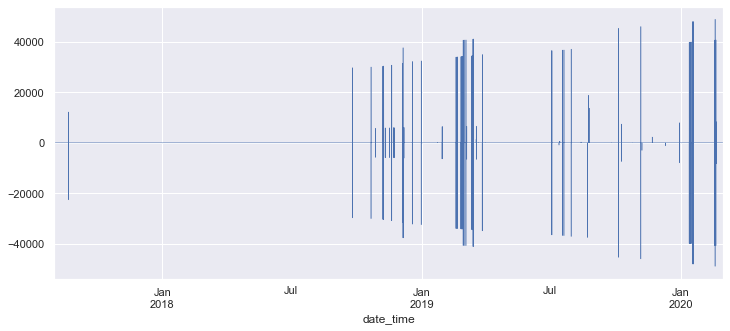

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)})
data['conso_global'].plot(linewidth=0.5)

In [ ]:
import math

Q1 = data['conso_global'].quantile(0.25)
Q3 = data['conso_global'].quantile(0.75)
IQR = Q3 - Q1

data[(data['conso_global'] < (Q1 - 1.5 * IQR)) | (data['conso_global'] > (Q3 + 1.5 * IQR))] = math.nan

# print('Lenght of outliers: {}'.format(len(rr)))
print('UIF = {} and LIF = {}'.format(Q3 + 1.5 * IQR,Q1 - 1.5 * IQR))

UIF = 5.555250000000001 and LIF = -2.8051500000000003


In [ ]:
#Replace anomalies with the values of the last days (same time)
one_week = 24*7
for idx in range(data.shape[0]):
    if (np.isnan(data.iloc[idx]['conso_global'])) or (data.iloc[idx]['conso_global']<0) :
        data.iloc[idx]['conso_global'] = data.iloc[idx-one_week]['conso_global']

<AxesSubplot:xlabel='date_time'>

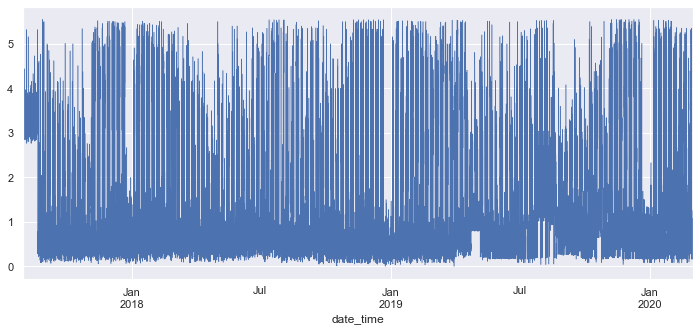

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
data['conso_global'].plot(linewidth=0.5)

In [ ]:
data["date"]= data.index
data

,conso_global,date
date_time,,
2017-08-01 00:00:00,3.0300,2017-08-01 00:00:00
2017-08-01 01:00:00,2.8600,2017-08-01 01:00:00
2017-08-01 02:00:00,2.8500,2017-08-01 02:00:00
2017-08-01 03:00:00,3.3600,2017-08-01 03:00:00
2017-08-01 04:00:00,3.0300,2017-08-01 04:00:00
...,...,...
2020-02-29 19:00:00,0.6699,2020-02-29 19:00:00
2020-02-29 20:00:00,0.3300,2020-02-29 20:00:00
2020-02-29 21:00:00,0.3300,2020-02-29 21:00:00


In [ ]:
data[data.conso_global.isnull()==True]

,conso_global,date
date_time,,


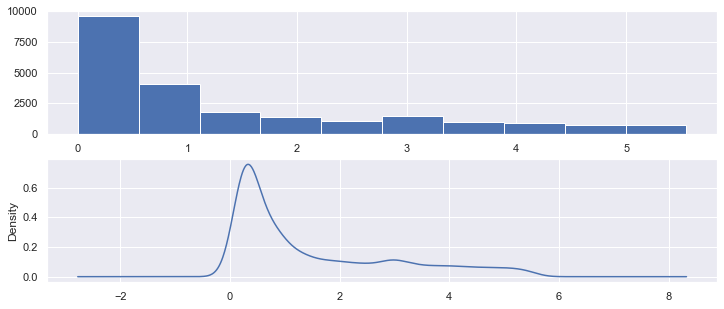

In [ ]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
data.conso_global.hist()
pyplot.subplot(212)
data.conso_global.plot(kind='kde')
pyplot.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array(data.conso_global).reshape(-1, 1))
scaled_data= scaler.transform(np.array(data.conso_global).reshape(-1, 1))
data['load'] = np.array(scaled_data).reshape(1, -1)[0]


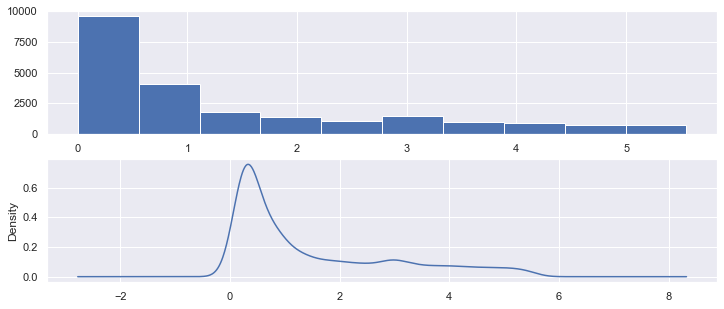

In [ ]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
data.conso_global.hist()
pyplot.subplot(212)
data.conso_global.plot(kind='kde')
pyplot.show()

In [ ]:
# from scipy.stats import boxcox
# bcx_target, lam = boxcox(data["load"])
# bcx_target= pd.DataFrame(bcx_target, columns=['trsf'])
# #lam is the best lambda for the distribution

In [ ]:
# bcx_target

In [ ]:
# from pandas import Series
# from matplotlib import pyplot
# pyplot.figure(1)
# pyplot.subplot(211)
# bcx_target.trsf.hist()
# pyplot.subplot(212)
# bcx_target.trsf.plot(kind='kde')
# pyplot.show()

In [ ]:
# data['target'] = bcx_target['trsf']

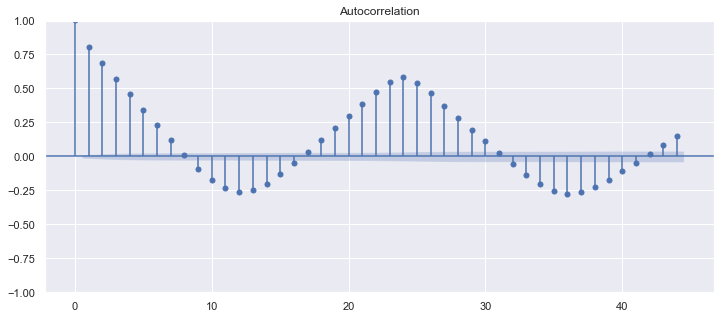

In [ ]:
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data.load)
pyplot.show()

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
acf_values = acf(data.load)

In [ ]:
acf_values

array([ 1.        ,  0.80219499,  0.68776655,  0.57262549,  0.45831446,
        0.34202917,  0.23262153,  0.12330869,  0.01224051, -0.08995464,
       -0.17324741, -0.23150926, -0.26554598, -0.24667325, -0.20120192,
       -0.13273997, -0.05043634,  0.03507286,  0.12288685,  0.21141133,
        0.29623769,  0.38354317,  0.47127086,  0.54968008,  0.58770985,
        0.53757546,  0.462845  ,  0.37098798,  0.28243834,  0.19658296,
        0.11447311,  0.02707407, -0.05899801, -0.13710201, -0.20602348,
       -0.25181856, -0.27739366, -0.26117673, -0.22826079, -0.17365568,
       -0.11045333, -0.04657161,  0.01776588,  0.08421422])

In [ ]:
data

,conso_global,date,load
date_time,,,
2017-08-01 00:00:00,3.0300,2017-08-01 00:00:00,0.545857
2017-08-01 01:00:00,2.8600,2017-08-01 01:00:00,0.515232
2017-08-01 02:00:00,2.8500,2017-08-01 02:00:00,0.513430
2017-08-01 03:00:00,3.3600,2017-08-01 03:00:00,0.605307
2017-08-01 04:00:00,3.0300,2017-08-01 04:00:00,0.545857
...,...,...,...
2020-02-29 19:00:00,0.6699,2020-02-29 19:00:00,0.120683
2020-02-29 20:00:00,0.3300,2020-02-29 20:00:00,0.059450
2020-02-29 21:00:00,0.3300,2020-02-29 21:00:00,0.059450


In [ ]:
pd.to_datetime(data['date'])

date_time
2017-08-01 00:00:00   2017-08-01 00:00:00
2017-08-01 01:00:00   2017-08-01 01:00:00
2017-08-01 02:00:00   2017-08-01 02:00:00
2017-08-01 03:00:00   2017-08-01 03:00:00
2017-08-01 04:00:00   2017-08-01 04:00:00
                              ...        
2020-02-29 19:00:00   2020-02-29 19:00:00
2020-02-29 20:00:00   2020-02-29 20:00:00
2020-02-29 21:00:00   2020-02-29 21:00:00
2020-02-29 22:00:00   2020-02-29 22:00:00
2020-02-29 23:00:00   2020-02-29 23:00:00
Name: date, Length: 22632, dtype: datetime64[ns]

In [ ]:
data["year"] = data["date"].apply(lambda x: x.year)

In [ ]:
data["hour"] = data["date"].apply(lambda x: x.hour)

In [ ]:
data["day_of_week"] = data["date"].apply(lambda x: x.dayofweek)

In [ ]:
data["month"] = data["date"].apply(lambda x: x.month)

In [ ]:
data.set_index(pd.to_datetime(data['date']), inplace=True)

In [ ]:
import holidays

de_holidays = holidays.France()
cet_dates = pd.Series(data.index, index=data.index)
data["holiday"] = cet_dates.apply(lambda d: d in de_holidays)
data["holiday"] = data["holiday"].astype(int)

In [ ]:
#lags
counter = np.arange(1,25)
# lags = np.arange(24*7, 24*8)
lags=[72, 73, 23+72, 24+72, 25+72, 47+72, 48+72]
lags = np.arange(72, 72+24)

lag_cols = [f"conso_lag_{cn}" for cn in lags ]
for lag, lag_col in zip(lags, lag_cols):
    data[lag_col] = data["load"].shift(lag)

In [ ]:
data.head(5)

,conso_global,date,load,year,hour,day_of_week,month,holiday,conso_lag_72,conso_lag_73,...,conso_lag_86,conso_lag_87,conso_lag_88,conso_lag_89,conso_lag_90,conso_lag_91,conso_lag_92,conso_lag_93,conso_lag_94,conso_lag_95
date,,,,,,,,,,,,,,,,,,,,,
2017-08-01 00:00:00,3.03,2017-08-01 00:00:00,0.545857,2017,0,1,8,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01 01:00:00,2.86,2017-08-01 01:00:00,0.515232,2017,1,1,8,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01 02:00:00,2.85,2017-08-01 02:00:00,0.513430,2017,2,1,8,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01 03:00:00,3.36,2017-08-01 03:00:00,0.605307,2017,3,1,8,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01 04:00:00,3.03,2017-08-01 04:00:00,0.545857,2017,4,1,8,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data.dropna(inplace=True)

In [ ]:
data

,conso_global,date,load,year,hour,day_of_week,month,holiday,conso_lag_72,conso_lag_73,...,conso_lag_86,conso_lag_87,conso_lag_88,conso_lag_89,conso_lag_90,conso_lag_91,conso_lag_92,conso_lag_93,conso_lag_94,conso_lag_95
date,,,,,,,,,,,,,,,,,,,,,
2017-08-04 23:00:00,3.0300,2017-08-04 23:00:00,0.545857,2017,23,4,8,0,0.644940,0.632330,...,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307,0.513430,0.515232,0.545857
2017-08-05 00:00:00,3.6600,2017-08-05 00:00:00,0.659353,2017,0,5,8,0,0.556666,0.644940,...,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307,0.513430,0.515232
2017-08-05 01:00:00,2.9000,2017-08-05 01:00:00,0.522438,2017,1,5,8,0,0.554865,0.556666,...,0.515232,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307,0.513430
2017-08-05 02:00:00,2.9000,2017-08-05 02:00:00,0.522438,2017,2,5,8,0,0.556666,0.554865,...,0.659353,0.515232,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857,0.605307
2017-08-05 03:00:00,2.9000,2017-08-05 03:00:00,0.522438,2017,3,5,8,0,0.535048,0.556666,...,0.616116,0.659353,0.515232,0.545857,0.524239,0.524239,0.526041,0.659353,0.544056,0.545857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 19:00:00,0.6699,2020-02-29 19:00:00,0.120683,2020,19,5,2,0,0.090075,0.272010,...,0.337225,0.167378,0.138698,0.209011,0.210759,0.331478,0.315246,0.284639,0.300870,0.178367
2020-02-29 20:00:00,0.3300,2020-02-29 20:00:00,0.059450,2020,20,5,2,0,0.090075,0.090075,...,0.696464,0.337225,0.167378,0.138698,0.209011,0.210759,0.331478,0.315246,0.284639,0.300870
2020-02-29 21:00:00,0.3300,2020-02-29 21:00:00,0.059450,2020,21,5,2,0,0.059450,0.090075,...,0.731953,0.696464,0.337225,0.167378,0.138698,0.209011,0.210759,0.331478,0.315246,0.284639


In [ ]:
features = ["hour", "day_of_week", "month", "holiday"]
# hours = pd.get_dummies(data["hour"])
# dows = pd.get_dummies(data["day_of_week"])
hours = data["hour"]
dows = data["day_of_week"]
months = data["month"]
holidays = data["holiday"]
# lags = data[lag_cols]
#,
X = np.c_[np.asarray(hours), np.asarray(dows), np.asarray(holidays)] #, np.asarray(lags)
num_features = X.shape[1]
num_periods = len(data)
X = np.asarray(X).reshape((-1, num_periods, num_features))
y = np.asarray(data["load"]).reshape((-1, num_periods))

In [ ]:
# args= { "num_epoches":100, "step_per_epoch": 3, "n_layers": 1, "likelihood": "g", "num_obs_to_train": 168, "show_plot": True, "run_test":True, "embedding_size": 10, "hidden_size": 50, "seq_len": 60, "mean_scaler":True, "lr":1e-3, "standard_scaler": False, "log_scaler":False, "batch_size": 64, "sample_size": 100 }

In [ ]:
# n_layers= 4
# hidden_size= 10
# batch_size= 32
# args= { "num_epoches":100, "step_per_epoch": 5, "n_layers": n_layers, "likelihood": "g", "num_obs_to_train": 24, "show_plot": True, "run_test":True, "embedding_size": 1, "hidden_size": hidden_size, "seq_len": 24, "mean_scaler":True, "lr":1e-3, "standard_scaler": False, "log_scaler":False, "batch_size": batch_size, "sample_size": 100 }

In [ ]:
n_layers= 3
hidden_size= 22
batch_size= 32
args= { "num_epoches":100, "step_per_epoch": 5, "n_layers": n_layers, "likelihood": "g", "num_obs_to_train": 7*24, "show_plot": True, "run_test":True, "embedding_size": 1, "hidden_size": hidden_size, "seq_len": 24, "mean_scaler":True, "lr":1e-3, "standard_scaler": False, "log_scaler":False, "batch_size": batch_size, "sample_size": 100 }

100% |########################################################################|
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.42it/s]


P50 MAPE: 0.674719781185412


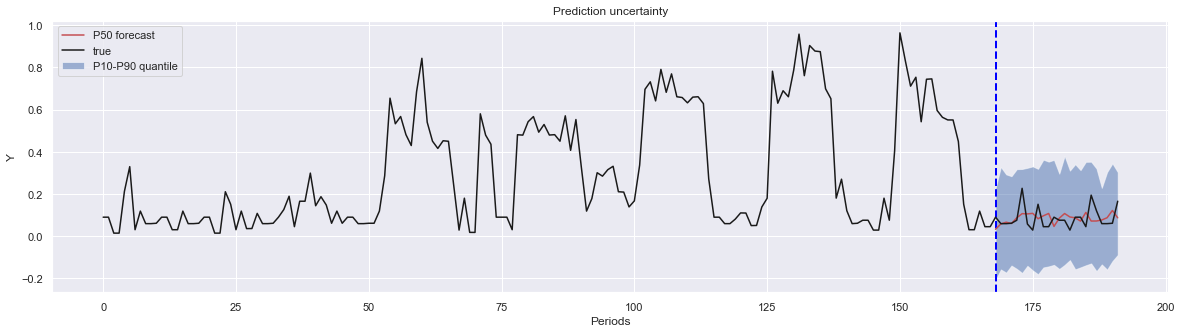

In [ ]:
losses, mape_list, yscaler, model, Xte, yte = train(X, y, args)

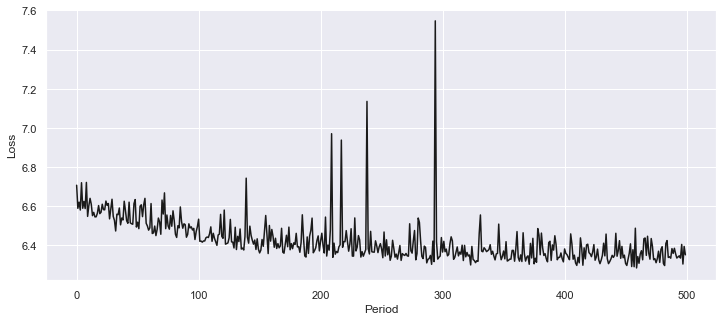

In [ ]:
plt.plot(range(len(losses)), losses, "k-")
plt.xlabel("Period")
plt.ylabel("Loss")
plt.show()

In [ ]:
num_ts, _, num_features = Xte.shape

num_obs_to_train=args["num_obs_to_train"]
seq_len = args["seq_len"]

In [ ]:
(Xte.shape[1]-seq_len) //num_obs_to_train

40

In [ ]:
# test

p50_list=[]
p90_list=[]
p10_list=[]
true_values=[]
pp = (Xte.shape[1]-seq_len) //num_obs_to_train
pp = 30
for k in tqdm(range(pp)):

    mape_list = []
    #create the test sets
    X_test = Xte[:, num_obs_to_train*k:num_obs_to_train*(k+1), :].reshape((num_ts, -1, num_features))
    Xf_test = Xte[:, num_obs_to_train*(k+1):seq_len+num_obs_to_train*(k+1), :].reshape((num_ts, -1, num_features))
    y_test = yte[:, num_obs_to_train*k:num_obs_to_train*(k+1)].reshape((num_ts, -1))
    yf_test = yte[:, num_obs_to_train*(k+1):seq_len+num_obs_to_train*(k+1)].reshape((num_ts, -1))


    # select skus with most top K
    # if yscaler is not None:
    #     y_test = yscaler.transform(y_test)
    result = []
    n_samples = args["sample_size"]
    progress = ProgressBar()
    for _ in progress(range(n_samples)):
        y_pred, _, _ = model(X_test, y_test, Xf_test)
        y_pred = y_pred.data.numpy()
        # if yscaler is not None:
        #     y_pred = yscaler.inverse_transform(y_pred)
        result.append(y_pred.reshape((-1, 1)))

    result = np.concatenate(result, axis=1)
    p50 = np.quantile(result, 0.5, axis=1)
    p90 = np.quantile(result, 0.9, axis=1)
    p10 = np.quantile(result, 0.1, axis=1)

    p50_list.append(p50)
    p90_list.append(p90)
    p10_list.append(p10)
    true_values.append(yf_test)


100% |########################################################################|                 | 0/30 [00:00<?, ?it/s]  0% |                                                                        |
100% |########################################################################|         | 1/30 [00:29<14:11, 29.37s/it]  0% |                                                                        |
100% |########################################################################|         | 2/30 [00:58<13:41, 29.35s/it]  0% |                                                                        |
100% |########################################################################|         | 3/30 [01:27<13:10, 29.30s/it]  0% |                                                                        |
100% |########################################################################|         | 4/30 [01:57<12:40, 29.24s/it]  0% |                                                                        |
100% 

In [ ]:
p90_list= np.array(p90_list).flatten()
p50_list= np.array(p50_list).flatten()
p10_list= np.array(p10_list).flatten()
true_values= np.array(true_values).flatten()

In [ ]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print(f"MAE: {mean_absolute_error(true_values, p50_list)}, RMSE: {mean_squared_error(true_values, p50_list) ** 0.5}, MAPE: {mean_absolute_percentage_error(true_values, p50_list)}")
print( "The accuracy of the model is: %f" %r2_score(true_values, p50_list))

MAE: 0.13999492266060998, RMSE: 0.19298619368733838, MAPE: 0.7408909453038794
The accuracy of the model is: 0.424560


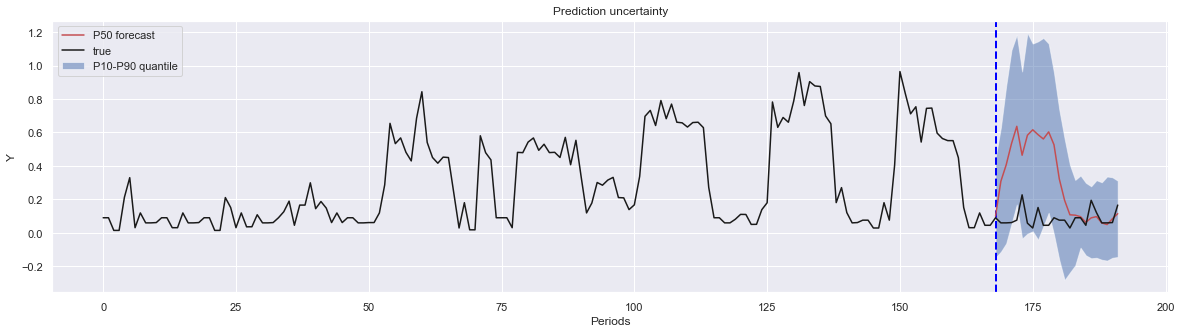

In [ ]:

plt.figure(1, figsize=(20, 5))
plt.plot([k + seq_len + num_obs_to_train - seq_len \
            for k in range(seq_len)], p50, "r-")
plt.fill_between(x=[k + seq_len + num_obs_to_train - seq_len for k in range(seq_len)], \
            y1=p10, y2=p90, alpha=0.5)
plt.title('Prediction uncertainty')
yplot = yte[-1, -seq_len-num_obs_to_train:]
plt.plot(range(len(yplot)), yplot, "k-")
plt.legend(["P50 forecast", "true", "P10-P90 quantile"], loc="upper left")
ymin, ymax = plt.ylim()
plt.vlines(seq_len + num_obs_to_train - seq_len, ymin, ymax, color="blue", linestyles="dashed", linewidth=2)
plt.ylim(ymin, ymax)
plt.xlabel("Periods")
plt.ylabel("Y")
plt.show()

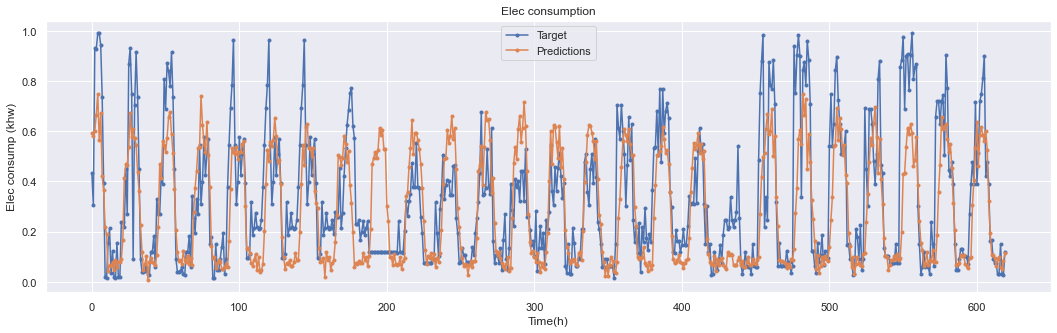

In [ ]:
plt.figure(figsize=(18,5))

plt.plot(true_values[100:800], marker='.',label='Target')
plt.plot(p50_list[100:800], marker='.', label='Predictions')
plt.title('Elec consumption')
plt.xlabel('Time(h)')
plt.ylabel('Elec consump (khw)')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
def quantile_loss(q, y, y_p):
        e = y-y_p
        return tf.keras.backend.mean(tf.keras.backend.maximum(q*e, (q-1)*e))
print("50%: {} and 90% {}".format(quantile_loss(0.5,true_values, p50_list),quantile_loss(0.9,true_values, p90_list)))

50%: 0.06999746133030499 and 90% 0.041720548414776716
